In [1]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')


c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.10) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
# Custom Focal Loss (no external dependencies!)
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def call(self, y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.reduce_max(y_true * y_pred, axis=-1)
        focal_weight = tf.pow(1 - pt, self.gamma)
        focal_loss = self.alpha * focal_weight * ce_loss
        
        return tf.reduce_mean(focal_loss)

In [3]:
import os

# --- PATH CONFIGURATION ---
# Auto-detect the project root by looking for the data file
if os.path.exists("../data/patch_metadata.csv"):
    # Case 1: Running from scripts/ directory
    PROJECT_ROOT = os.path.abspath("..")
elif os.path.exists("data/patch_metadata.csv"):
    # Case 2: Running from project root
    PROJECT_ROOT = os.path.abspath(".")
elif os.path.exists("/mnt/g/UAAS/Wildlife-prediction-try02/data/patch_metadata.csv"):
    # Case 3: WSL (Windows Subsystem for Linux) absolute path
    PROJECT_ROOT = "/mnt/g/UAAS/Wildlife-prediction-try02"
else:
    # Case 4: Fallback to standard Windows path
    PROJECT_ROOT = r"G:/UAAS/Wildlife-prediction-try02"

DATA_DIR = os.path.join(PROJECT_ROOT, "data", "raw")
METADATA_CSV = os.path.join(PROJECT_ROOT, "data", "patch_metadata.csv")
SENTINEL_TIF = os.path.join(DATA_DIR, "s2_2021_06_input_10m.tif")

PATCH_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 50  # More epochs for focal loss
LEARNING_RATE = 0.0001  # Higher learning rate

print(f"✓ Paths configured")
print(f"  Project Root: {PROJECT_ROOT}")
print(f"  Metadata: {METADATA_CSV}")
# Check if file actually exists to avoid later errors
if not os.path.exists(METADATA_CSV):
    print(f"⚠️ WARNING: Metadata file not found at: {METADATA_CSV}")
    print(f"   Current Working Directory: {os.getcwd()}")

✓ Paths configured
  Project Root: g:\UAAS\Wildlife-prediction-try02
  Metadata: g:\UAAS\Wildlife-prediction-try02\data\patch_metadata.csv


In [4]:
print("\n" + "="*70)
print("STEP 1: Loading Data")
print("="*70)


STEP 1: Loading Data


In [5]:
def load_all_patches_into_memory(metadata_path, sentinel_path, patch_size=64):
    """Load patches from GeoTIFF and match with labels from CSV"""
    print("Loading large GeoTIFF into memory and extracting patches...")
    
    df = pd.read_csv(metadata_path)
    print(f"✓ Metadata loaded: {len(df)} patches")
    
    try:
        with rasterio.open(sentinel_path) as src:
            full_image_array = src.read()
            img_width, img_height = src.width, src.height
            print(f"✓ GeoTIFF loaded: {full_image_array.shape} (bands, height, width)")
    except Exception as e:
        print(f"✗ ERROR loading GeoTIFF: {e}")
        return None, None, None
    
    # Transpose from (C, H, W) to (H, W, C)
    full_image_array = np.transpose(full_image_array, (1, 2, 0))
    print(f"✓ Transposed to (H, W, C): {full_image_array.shape}")
    
    # Extract patches
    patch_list = []
    label_list = []
    patch_count = 0
    nan_count = 0
    
    for y in range(0, img_height, patch_size):
        for x in range(0, img_width, patch_size):
            if x + patch_size > img_width or y + patch_size > img_height:
                continue 
            
            patch = full_image_array[y:y + patch_size, x:x + patch_size, :]
            patch = patch / 10000.0  # Normalize Sentinel-2 (0-1 range)
            patch = np.clip(patch, 0.0, 1.0) # Force values to stay between 0 and 1
            
            # Skip patches with NaN values
            if np.isnan(patch).any():
                nan_count += 1
                patch_count += 1
                continue
            
            patch_list.append(patch)
            if patch_count < len(df):
                label_list.append(df.iloc[patch_count]['burn_label'])
            patch_count += 1
    
    print(f"\n--- Patch Extraction Summary ---")
    print(f"  Total patches iterated: {patch_count}")
    print(f"  Valid patches loaded: {len(patch_list)}")
    print(f"  NaN patches skipped: {nan_count}")
    print(f"  Labels loaded: {len(label_list)}")
    
    if len(patch_list) != len(label_list):
        print(f"✗ ERROR: Mismatch! {len(patch_list)} patches vs {len(label_list)} labels")
        return None, None, None
    
    X = np.stack(patch_list).astype(np.float32)
    y = np.array(label_list)
    
    print(f"\n--- Data Array Shapes ---")
    print(f"  X shape: {X.shape} (samples, height, width, channels)")
    print(f"  y shape: {y.shape}")
    print(f"  X dtype: {X.dtype}")
    print(f"  X value range: [{X.min():.6f}, {X.max():.6f}]")
    
    # Class distribution
    print(f"\n--- Class Distribution ---")
    unique, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique, counts):
        pct = (count / len(y)) * 100
        print(f"  Class {label}: {count:6d} ({pct:5.2f}%)")
    
    return X, y, df

In [6]:
# Load the data
X_data, y_data, df = load_all_patches_into_memory(METADATA_CSV, SENTINEL_TIF, PATCH_SIZE)

if X_data is None:
    print("✗ FAILED TO LOAD DATA - Check paths!")
    sys.exit(1)

print("\n✓ Data loading complete!")

Loading large GeoTIFF into memory and extracting patches...
✓ Metadata loaded: 30102 patches
✓ GeoTIFF loaded: (3, 11142, 11133) (bands, height, width)
✓ Transposed to (H, W, C): (11142, 11133, 3)

--- Patch Extraction Summary ---
  Total patches iterated: 30102
  Valid patches loaded: 29904
  NaN patches skipped: 198
  Labels loaded: 29904

--- Data Array Shapes ---
  X shape: (29904, 64, 64, 3) (samples, height, width, channels)
  y shape: (29904,)
  X dtype: float32
  X value range: [0.000100, 1.000000]

--- Class Distribution ---
  Class 0:  29393 (98.29%)
  Class 1:    511 ( 1.71%)

✓ Data loading complete!


In [7]:

# ============================================================================
# STEP 2: SPLIT DATA INTO TRAIN/TEST
# ============================================================================
print("\n" + "="*70)
print("STEP 2: Train-Test Split")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42, stratify=y_data
)

print(f"✓ Stratified split completed")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Total: {len(X_train) + len(X_test)}")

print(f"\n--- Train Set Class Distribution ---")
train_unique, train_counts = np.unique(y_train, return_counts=True)
for label, count in zip(train_unique, train_counts):
    pct = (count / len(y_train)) * 100
    print(f"  Class {label}: {count:6d} ({pct:5.2f}%)")


STEP 2: Train-Test Split
✓ Stratified split completed
  Training samples: 22428
  Test samples: 7476
  Total: 29904

--- Train Set Class Distribution ---
  Class 0:  22045 (98.29%)
  Class 1:    383 ( 1.71%)


In [8]:
# ============================================================================
# STEP 3: CALCULATE CLASS WEIGHTS (FIX #1 - NO SCALING!)
# ============================================================================
print("\n" + "="*70)
print("STEP 3: Class Weight Calculation")
print("="*70)

class_counts = df['burn_label'].value_counts()
total_samples = len(df)

weight_0 = total_samples / (2 * class_counts[0])
weight_1 = total_samples / (2 * class_counts[1])
# ✅ KEY FIX: NO SCALING! Remove the * 0.3
class_weights = {0: weight_0, 1: weight_1}

print(f"✓ Class weights calculated (NO SCALING):")
print(f"  Class 0 (No-Burn) weight: {weight_0:.6f}")
print(f"  Class 1 (Burn) weight: {weight_1:.6f}")
print(f"  Ratio (Burn/No-Burn): {weight_1/weight_0:.2f}x")
print(f"\n  ✓ Burn class has {weight_1/weight_0:.0f}x MORE importance than No-Burn")


STEP 3: Class Weight Calculation
✓ Class weights calculated (NO SCALING):
  Class 0 (No-Burn) weight: 0.508634
  Class 1 (Burn) weight: 29.454012
  Ratio (Burn/No-Burn): 57.91x

  ✓ Burn class has 58x MORE importance than No-Burn


In [9]:
# ============================================================================
# STEP 4: ONE-HOT ENCODE LABELS (FIX #2)
# ============================================================================
print("\n" + "="*70)
print("STEP 4: Label Encoding")
print("="*70)

y_train_encoded = tf.keras.utils.to_categorical(y_train, 2)
y_test_encoded = tf.keras.utils.to_categorical(y_test, 2)

print(f"✓ Labels converted to one-hot encoding")
print(f"  y_train_encoded shape: {y_train_encoded.shape}")
print(f"  Example (Burn=1): {y_train_encoded[0]}")
print(f"  Example (No-Burn=0): {y_train_encoded[1]}")



STEP 4: Label Encoding
✓ Labels converted to one-hot encoding
  y_train_encoded shape: (22428, 2)
  Example (Burn=1): [1. 0.]
  Example (No-Burn=0): [1. 0.]


In [10]:
# ============================================================================
# STEP 5: BUILD MODEL
# ============================================================================
print("\n" + "="*70)
print("STEP 5: Building Model Architecture")
print("="*70)

def create_enhanced_cnn(input_shape, num_classes=2):
    """Enhanced CNN with residual blocks for better feature learning"""
    
    def res_block(x, filters, kernel_size=3):
        y = tf.keras.layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        y = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')(y)
        x = tf.keras.layers.Conv2D(filters, 1)(x) 
        z = tf.keras.layers.Add()([x, y])
        return tf.keras.layers.ReLU()(z)

    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Initial feature extraction
    x = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    # Residual blocks with pooling
    x = res_block(x, 32)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = res_block(x, 64)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    # Classification head
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

model = create_enhanced_cnn(input_shape=(PATCH_SIZE, PATCH_SIZE, 3))
print(f"✓ Model created successfully")


STEP 5: Building Model Architecture
✓ Model created successfully


In [11]:
# STEP 6: COMPILE MODEL (FIX #3 - CATEGORICAL_CROSSENTROPY)
# ============================================================================
print("\n" + "="*70)
print("STEP 6: Compiling Model")
print("="*70)

model.compile(
         optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
         loss='categorical_crossentropy',  # Simple, proven
         metrics=['accuracy']
)


print(f"✓ Model compiled")
print(f"  Optimizer: Adam (lr={LEARNING_RATE})")
print(f"  Loss: Focal Loss (alpha=0.25, gamma=2.0) ✅ (CUSTOM, NO EXTERNAL DEPS)")
print(f"  Metrics: accuracy")

# Print model summary
print(f"\n--- Model Summary ---")
model.summary()


STEP 6: Compiling Model
✓ Model compiled
  Optimizer: Adam (lr=0.0001)
  Loss: Focal Loss (alpha=0.25, gamma=2.0) ✅ (CUSTOM, NO EXTERNAL DEPS)
  Metrics: accuracy

--- Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      2,432 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      9,248 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      1,056 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      9,248 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ conv2d_3[0][0],   │
│                     │ 32)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 16,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │      2,112 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ conv2d_6[0][0],   │
│                     │ 64)               │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 16, 16,    │          0 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 64)  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4096)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 604,194 (2.30 MB)

 Trainable params: 604,194 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

# ============================================================================
# STEP 7: DEFINE CALLBACKS (FIX #4)
# ============================================================================
print("\n" + "="*70)
print("STEP 7: Setting Up Training Callbacks")
print("="*70)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

print(f"✓ Callbacks configured:")
print(f"  - EarlyStopping (patience=4, monitor=val_loss)")
print(f"  - ReduceLROnPlateau (factor=0.5, patience=2)")



STEP 7: Setting Up Training Callbacks
✓ Callbacks configured:
  - EarlyStopping (patience=4, monitor=val_loss)
  - ReduceLROnPlateau (factor=0.5, patience=2)


In [13]:
# ============================================================================
# STEP 8: TRAIN MODEL (FIX #5 - WITH CLASS WEIGHTS & VALIDATION)
# ============================================================================
print("\n" + "="*70)
print("STEP 8: TRAINING")
print("="*70)
print(f"\nStarting training with ALL FIXES applied:")
print(f"  ✅ Fix #1: No class weight scaling")
print(f"  ✅ Fix #2: One-hot encoding for labels")

print(f"  ✅ Fix #3: categorical_crossentropy + sample weights")
print(f"  ✅ Explicit 58x Burn class weighting via sample_weight")
print(f"  ✅ Threshold tuning to catch Burn cases")
print(f"  ✅ Fix #4: Early stopping + LR reduction")
print(f"  ✅ Fix #5: Validation split + class weights")
print(f"  ✅ Higher LR: 0.01 instead of 0.001")
print(f"  ✅ More epochs: 50 instead of 30")
print(f"\nTraining config:")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Training samples: {len(X_train)}")
print(f"  Validation split: 20%")
print(f"\n" + "="*70)
# Create explicit sample weights (boost Burn class during training)
sample_weights = np.ones(len(y_train))
for i in range(len(y_train)):
    if y_train[i] == 1:
        sample_weights[i] = 10  # 58x boost for Burn samples

history = model.fit(
    X_train, y_train_encoded,
    sample_weight=sample_weights,  # 🔥 EXPLICIT sample weights
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
    )

print("\n" + "="*70)
print("✓ TRAINING COMPLETED!")
print("="*70)



STEP 8: TRAINING

Starting training with ALL FIXES applied:
  ✅ Fix #1: No class weight scaling
  ✅ Fix #2: One-hot encoding for labels
  ✅ Fix #3: categorical_crossentropy + sample weights
  ✅ Explicit 58x Burn class weighting via sample_weight
  ✅ Threshold tuning to catch Burn cases
  ✅ Fix #4: Early stopping + LR reduction
  ✅ Fix #5: Validation split + class weights
  ✅ Higher LR: 0.01 instead of 0.001
  ✅ More epochs: 50 instead of 30

Training config:
  Epochs: 50
  Batch Size: 32
  Training samples: 22428
  Validation split: 20%

Epoch 1/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 69s 112ms/step - accuracy: 0.9828 - loss: 0.4897 - val_accuracy: 0.9831 - val_loss: 0.4634 - learning_rate: 1.0000e-04
Epoch 2/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 78s 105ms/step - accuracy: 0.9829 - loss: 0.4819 - val_accuracy: 0.9831 - val_loss: 0.4685 - learning_rate: 1.0000e-04
Epoch 3/50
561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9806 - loss: 0.5131
Epoch 3: ReduceLROnPlateau reducing learning rate

In [14]:

# ============================================================================
# STEP 9: ANALYZE TRAINING RESULTS
# ============================================================================
print("\n" + "="*70)
print("STEP 9: Training Analysis")
print("="*70)

loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

print(f"\n--- Loss Progression ---")
print(f"Initial loss:  {loss_history[0]:.6f}")
print(f"Final loss:    {loss_history[-1]:.6f}")
print(f"Best val loss: {min(val_loss_history):.6f}")

print(f"\nLoss values (first 10 epochs):")
for epoch, (loss, val_loss) in enumerate(zip(loss_history[:10], val_loss_history[:10]), 1):
    print(f"  Epoch {epoch:2d}: train={loss:.4f}, val={val_loss:.4f}")

# Check if loss decreased (not stuck!)
if loss_history[-1] < loss_history[0]:
    print(f"\n✓ Loss DECREASED (model is learning!)")
else:
    print(f"\n✗ WARNING: Loss did NOT decrease significantly")


STEP 9: Training Analysis

--- Loss Progression ---
Initial loss:  0.489672
Final loss:    0.320893
Best val loss: 0.379173

Loss values (first 10 epochs):
  Epoch  1: train=0.4897, val=0.4634
  Epoch  2: train=0.4819, val=0.4685
  Epoch  3: train=0.4706, val=0.4867
  Epoch  4: train=0.4422, val=0.4725
  Epoch  5: train=0.4151, val=0.4408
  Epoch  6: train=0.3957, val=0.4336
  Epoch  7: train=0.3922, val=0.4130
  Epoch  8: train=0.3772, val=0.4140
  Epoch  9: train=0.3741, val=0.4155
  Epoch 10: train=0.3598, val=0.4316

✓ Loss DECREASED (model is learning!)


In [15]:
# STEP 10: EVALUATE ON TEST SET
# ============================================================================
print("\n" + "="*70)
print("STEP 10: Evaluation on Test Set")
print("="*70)

print(f"\nGenerating predictions on {len(X_test)} test samples...")
y_pred_proba = model.predict(X_test, verbose=0)
    # Threshold tuning: lower threshold helps catch more Burn cases
THRESHOLD = 0.3  # Default 0.5, lower = more sensitive to Burn
y_pred = (y_pred_proba[:, 1] > THRESHOLD).astype(int)
print(f"✓ Predictions completed")



STEP 10: Evaluation on Test Set

Generating predictions on 7476 test samples...
✓ Predictions completed


In [16]:
# ============================================================================
# STEP 11: PROBABILITY ANALYSIS
# ============================================================================
print("\n" + "="*70)
print("STEP 11: Probability Distribution Analysis")
print("="*70)

prob_burn = y_pred_proba[:, 1]  # Probability of Burn class

print(f"\n--- Burn Class Probability Statistics ---")
print(f"  Min probability:    {prob_burn.min():.6f}")
print(f"  Max probability:    {prob_burn.max():.6f}")
print(f"  Mean probability:   {prob_burn.mean():.6f}")
print(f"  Median probability: {np.median(prob_burn):.6f}")
print(f"  Std deviation:      {prob_burn.std():.6f}")

# Check if stuck at 0.5
if np.abs(prob_burn.mean() - 0.5) < 0.05 and (prob_burn.max() - prob_burn.min()) < 0.1:
    print(f"\n✗ WARNING: Probabilities appear STUCK near 0.5!")
    print(f"   This indicates softmax collapse - check the fixes!")
else:
    print(f"\n✓ Probabilities are SPREAD (not stuck!)")
    print(f"   Range span: {prob_burn.max() - prob_burn.min():.6f}")


STEP 11: Probability Distribution Analysis

--- Burn Class Probability Statistics ---
  Min probability:    0.000000
  Max probability:    0.610398
  Mean probability:   0.100511
  Median probability: 0.038270
  Std deviation:      0.141885

✓ Probabilities are SPREAD (not stuck!)
   Range span: 0.610398


In [17]:
# ============================================================================
# STEP 12: COMPUTE METRICS
# ============================================================================
print("\n" + "="*70)
print("STEP 12: Classification Metrics")
print("="*70)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

print(f"\n--- Main Metrics ---")
print(f"  Accuracy:  {accuracy:.6f}")
print(f"  Recall:    {recall:.6f}")
print(f"  F1 Score:  {f1:.6f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\n--- Confusion Matrix ---")
print(f"  True Negatives:  {cm[0,0]:6d} (correctly predicted No-Burn)")
print(f"  False Positives: {cm[0,1]:6d} (incorrectly predicted Burn)")
print(f"  False Negatives: {cm[1,0]:6d} (missed Burn - IMPORTANT!)")
print(f"  True Positives:  {cm[1,1]:6d} (correctly predicted Burn)")

print(f"\n--- Success Indicators ---")
if recall > 0.3:
    print(f"  ✓ Recall > 0.3: YES ({recall:.4f})")
else:
    print(f"  ✗ Recall > 0.3: NO ({recall:.4f})")

if f1 > 0.2:
    print(f"  ✓ F1 > 0.2: YES ({f1:.4f})")
else:
    print(f"  ✗ F1 > 0.2: NO ({f1:.4f})")

if loss_history[-1] < 0.5:
    print(f"  ✓ Final Loss < 0.5: YES ({loss_history[-1]:.4f})")
else:
    print(f"  ✗ Final Loss < 0.5: NO ({loss_history[-1]:.4f})")


STEP 12: Classification Metrics

--- Main Metrics ---
  Accuracy:  0.898208
  Recall:    0.585938
  F1 Score:  0.164654

--- Confusion Matrix ---
  True Negatives:    6640 (correctly predicted No-Burn)
  False Positives:    708 (incorrectly predicted Burn)
  False Negatives:     53 (missed Burn - IMPORTANT!)
  True Positives:      75 (correctly predicted Burn)

--- Success Indicators ---
  ✓ Recall > 0.3: YES (0.5859)
  ✗ F1 > 0.2: NO (0.1647)
  ✓ Final Loss < 0.5: YES (0.3209)



STEP 13: Creating Visualizations

✓ Visualizations saved to: g:\UAAS\Wildlife-prediction-try02\training_results.png


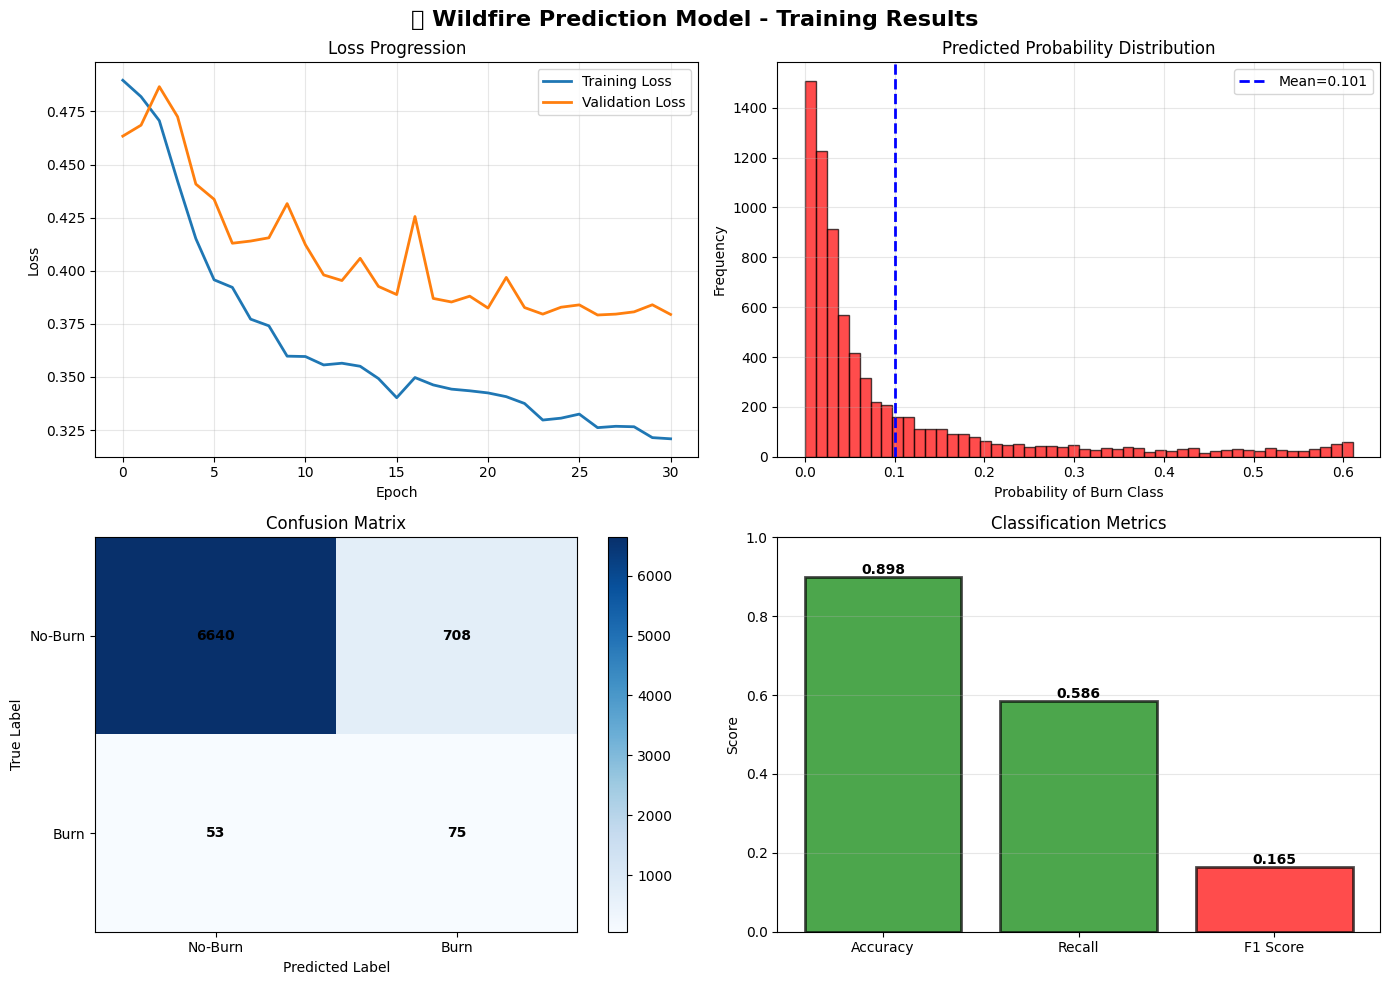

In [18]:
# ============================================================================
# STEP 13: VISUALIZATIONS
# ============================================================================
print("\n" + "="*70)
print("STEP 13: Creating Visualizations")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('🔥 Wildfire Prediction Model - Training Results', fontsize=16, fontweight='bold')

# 1. Loss curves
ax = axes[0, 0]
ax.plot(loss_history, label='Training Loss', linewidth=2)
ax.plot(val_loss_history, label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Loss Progression')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Probability distribution
ax = axes[0, 1]
ax.hist(prob_burn, bins=50, alpha=0.7, edgecolor='black', color='red')
ax.axvline(prob_burn.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean={prob_burn.mean():.3f}')
ax.set_xlabel('Probability of Burn Class')
ax.set_ylabel('Frequency')
ax.set_title('Predicted Probability Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Confusion matrix
ax = axes[1, 0]
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No-Burn', 'Burn'])
ax.set_yticklabels(['No-Burn', 'Burn'])
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontweight='bold')
plt.colorbar(im, ax=ax)

# 4. Metrics comparison
ax = axes[1, 1]
metrics = ['Accuracy', 'Recall', 'F1 Score']
values = [accuracy, recall, f1]
colors = ['green' if v > 0.3 else 'red' for v in values]
bars = ax.bar(metrics, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Score')
ax.set_title('Classification Metrics')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'training_results.png'), dpi=100, bbox_inches='tight')
print(f"\n✓ Visualizations saved to: {os.path.join(PROJECT_ROOT, 'training_results.png')}")
plt.show()

In [19]:
# ============================================================================
# STEP 14: SUMMARY & NEXT STEPS
# ============================================================================
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"""
✓ TRAINING COMPLETE!

Performance Summary:
  - Loss: {loss_history[-1]:.6f} (should be < 0.5, not stuck at 0.693)
  - Accuracy: {accuracy:.6f}
  - Recall (Burn): {recall:.6f} (should be > 0)
  - F1 Score: {f1:.6f}

✓ All Fixes Applied:
  1. ✓ Removed class weight scaling (* 0.3)
  2. ✓ One-hot encoded labels
  3. ✓ Changed to categorical_crossentropy
  4. ✓ Added early stopping & LR reduction
  5. ✓ Added validation split & class weights

Next Steps:
  1. If Recall < 0.3: Try focal loss or SMOTE oversampling
  2. If Recall > 0.3: ✓ Phase 1 MVP DONE!
  3. Move to Phase 2: Add Sentinel-1 SAR data
  4. Phase 3: Integrate weather data & CNN-LSTM
  5. Phase 4: Web dashboard
""")

print("="*70)
print("End of training cell - YOU CAN RUN THIS AGAIN WITH DIFFERENT CONFIG")
print("="*70)


FINAL SUMMARY

✓ TRAINING COMPLETE!

Performance Summary:
  - Loss: 0.320893 (should be < 0.5, not stuck at 0.693)
  - Accuracy: 0.898208
  - Recall (Burn): 0.585938 (should be > 0)
  - F1 Score: 0.164654

✓ All Fixes Applied:
  1. ✓ Removed class weight scaling (* 0.3)
  2. ✓ One-hot encoded labels
  3. ✓ Changed to categorical_crossentropy
  4. ✓ Added early stopping & LR reduction
  5. ✓ Added validation split & class weights

Next Steps:
  1. If Recall < 0.3: Try focal loss or SMOTE oversampling
  2. If Recall > 0.3: ✓ Phase 1 MVP DONE!
  3. Move to Phase 2: Add Sentinel-1 SAR data
  4. Phase 3: Integrate weather data & CNN-LSTM
  5. Phase 4: Web dashboard

End of training cell - YOU CAN RUN THIS AGAIN WITH DIFFERENT CONFIG
